# KNN
Use K nearest neighbors for our regression problem.

In [17]:

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 

In [18]:
# Open dataset
filename: str = 'dataset.csv'
dataset = pd.read_pickle('dataRead_processed.pkl.bz2', compression='bz2')

# Split dataset
X = dataset.drop(columns=['total_passengers_2022'])
y = dataset['total_passengers_2022']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
# Define common functions (metrics for instance)
def comptue_metrics(y_pred, y_real):
    r2 = r2_score(y_pred,y_real)
    mse = mean_squared_error(y_pred, y_real)
    median_abs_e = median_absolute_error(y_pred, y_real)
    mean_abs_e = mean_absolute_error(y_pred, y_real)
    return [r2, mse, median_abs_e, mean_abs_e]

In [20]:
# We also instantiate our results dataframe
results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    # Remove non numeric columns
    X = X.select_dtypes(include=[np.number])
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    # Normalize
    X = minmax_scale(X)
    print('New shape:{}'.format(X.shape))
    return X, y

X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(1491, 38)
New shape:(1491, 30)
Original shape:(735, 38)
New shape:(735, 30)


,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
KNN,-,-,-,0.936297,106177240378.037476,12694.8,99470.722449


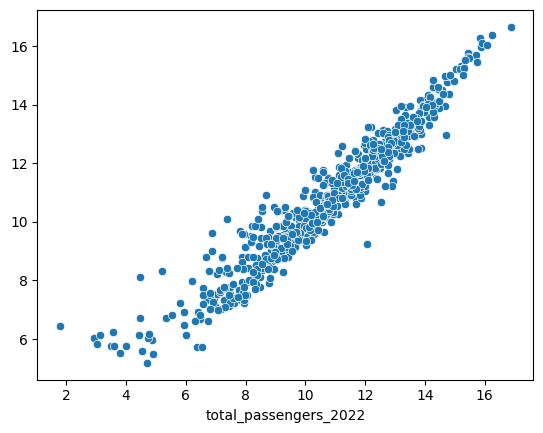

In [21]:
# Simple KNN model
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

results.loc['KNN', :] = ['-', '-', '-'] + comptue_metrics(y_pred,y_test)

sns.scatterplot(x=np.log(y_test), y=np.log(y_pred))
results

## Parameter tuning: k of k nearest neighbors

In [22]:
# More complex model
train_score = {}
test_score = {}
n_neighbors = np.arange(1, 30, 1)

for neighbor in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test, y_test)

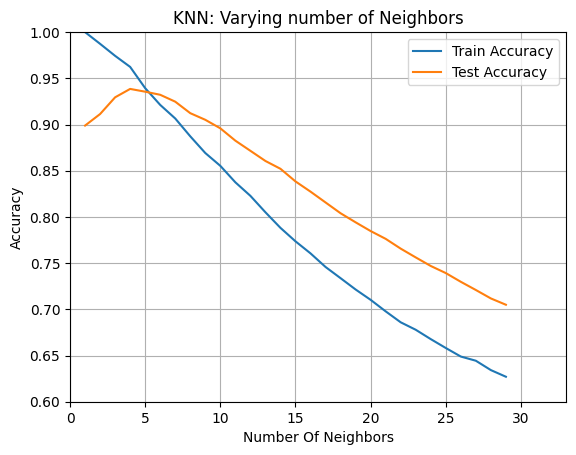

In [23]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.60, 1)
plt.grid()
plt.show()

In [24]:
from sklearn.model_selection import KFold

# Parameter tuning
kf=KFold(n_splits=20,shuffle=True,random_state=42)
parameter={'n_neighbors': np.arange(2, 30, 1)}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn, param_grid=parameter, cv=kf, verbose=1)
knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)

Fitting 20 folds for each of 28 candidates, totalling 560 fits
{'n_neighbors': 2}


<Axes: xlabel='total_passengers_2022'>

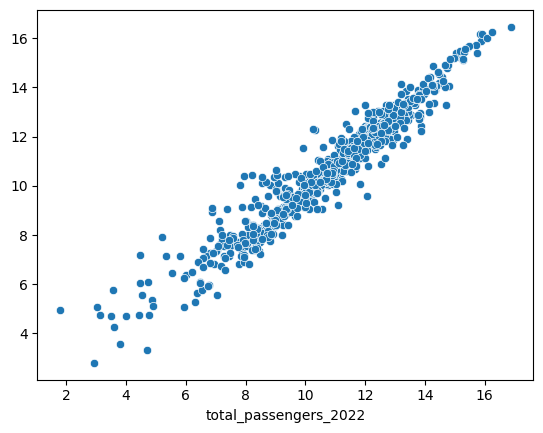

In [25]:
from sklearn.metrics import accuracy_score

best_k = knn_cv.best_params_['n_neighbors']
# Use the best hyperparameter and train the final model
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


sns.scatterplot(x=np.log(y_test), y=np.log(y_pred))